<a href="https://colab.research.google.com/github/rlberry-py/rlberry/blob/main/notebooks/introduction_to_rlberry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to
<img src="https://raw.githubusercontent.com/rlberry-py/rlberry/main/assets/logo_wide.svg" width="700"/>




# Colab setup

In [1]:
# install rlberry library
!git clone https://github.com/rlberry-py/rlberry.git 
!cd rlberry && git pull && pip install -e . > /dev/null 2>&1

# install ffmpeg-python for saving videos
!pip install ffmpeg-python > /dev/null 2>&1

# install optuna for hyperparameter optimization
!pip install optuna > /dev/null 2>&1

# packages required to show video
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

print("")
print(" ~~~  Libraries installed, please restart the runtime! ~~~ ")
print("")


fatal: destination path 'rlberry' already exists and is not an empty directory.
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/rlberry-py/rlberry
   f2abf19..ea58731  main       -> origin/main
Updating f2abf19..ea58731
Fast-forward
 rlberry/stats/agent_stats.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)

 ~~~  Libraries installed, please restart the runtime! ~~~ 



In [2]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

# Interacting with a simple environment

In [3]:
from rlberry.envs import GridWorld

# A grid world is a simple environment with finite states and actions, on which 
# we can test simple algorithms.
# -> The reward function can be accessed by: env.R[state, action]
# -> And the transitions: env.P[state, action, next_state]
env = GridWorld(nrows=3, ncols=10,
                reward_at = {(1,1):0.1, (2, 9):1.0},
                walls=((1,4),(2,4), (1,5)),
                success_probability=0.9)


# Let's visuzalize a random policy in this environment!
env.enable_rendering()
env.reset()
for tt in range(20):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)

# save video and clear buffer
env.save_video('./videos/gw.mp4', framerate=5)
env.clear_render_buffer()
# show video
show_video('./videos/gw.mp4')

videos/gw.mp4


# Creating an agent

Let's create an agent that runs value iteration to find a near-optimal policy.
This is possible in our GridWorld, because we have access to the transitions `env.P` and the rewards `env.R`.


An Agent must implement at least two methods, **fit()** and **policy()**.

It can also implement **sample_parameters()** used for hyperparameter optimization with [Optuna](https://optuna.org/).


In [4]:
import numpy as np
from rlberry.agents import Agent

class ValueIterationAgent(Agent):
    name = 'ValueIterationAgent'
    def __init__(self, env, gamma=0.99, epsilon=1e-5, **kwargs):   # it's important to put **kwargs to ensure compatibility with the base class 
        """
        gamma: discount factor
        episilon: precision of value iteration
        """
        Agent.__init__(self, env, **kwargs) # self.env is initialized in the base class

        self.gamma = gamma
        self.epsilon = epsilon 
        self.Q = None  # Q function to be computed in fit()
    
    def fit(self, **kwargs):  
        """
        Run value iteration.
        """
        S, A = env.observation_space.n, env.action_space.n 
        Q = np.zeros((S, A))
        V = np.zeros(S)

        while True:
            TQ = np.zeros((S, A))
            for ss in range(S):
                for aa in range(A):
                    TQ[ss, aa] = env.R[ss, aa] + self.gamma*env.P[ss, aa, :].dot(V)
            V = TQ.max(axis=1)

            if np.abs(TQ-Q).max() < self.epsilon:
                break
            Q = TQ
        self.Q = Q
          
    def policy(self, observation, **kwargs):
        return self.Q[observation, :].argmax()

    
    @classmethod
    def sample_parameters(cls, trial):
      """
      Sample hyperparameters for hyperparam optimization using Optuna (https://optuna.org/)
      """
      gamma = trial.suggest_categorical('gamma', [0.1, 0.25, 0.5, 0.75, 0.99])
      return {'gamma':gamma}


In [5]:
# Now, let's fit and test the agent!
agent = ValueIterationAgent(env)
agent.fit()


# Run agent's policy
env.enable_rendering()
state = env.reset()
for tt in range(20):
    action = agent.policy(state)
    state, reward, is_terminal, info = env.step(action)

# save video and clear buffer
env.save_video('./videos/gw.mp4', framerate=5)
env.clear_render_buffer()
# show video
show_video('./videos/gw.mp4')


videos/gw.mp4


# `AgentStats`: A powerfull class for hyperparameter optimization, training and evaluating agents.

In [6]:
# Create random agent as a baseline
class RandomAgent(Agent):
    name = 'RandomAgent'
    def __init__(self, env, gamma=0.99, epsilon=1e-5, **kwargs):   # it's important to put **kwargs to ensure compatibility with the base class 
        """
        gamma: discount factor
        episilon: precision of value iteration
        """
        Agent.__init__(self, env, **kwargs) # self.env is initialized in the base class

    def fit(self, **kwargs):  
        pass
          
    def policy(self, observation, **kwargs):
        return self.env.action_space.sample()


 Training AgentStats for ValueIterationAgent... 


 ... trained! 


 Training AgentStats for RandomAgent... 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.6s finished



 ... trained! 



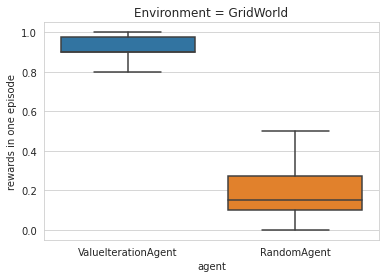

In [7]:
from rlberry.stats import AgentStats, evaluate_policies

# Define parameters
vi_params = {'gamma':0.1, 'epsilon':1e-3}

# Create AgentStats to fit 4 agents using 1 job
vi_stats = AgentStats(ValueIterationAgent, env, eval_horizon=20, init_kwargs=vi_params, n_fit=4, n_jobs=1)
vi_stats.fit()

# Create AgentStats for baseline
baseline_stats = AgentStats(RandomAgent, env, eval_horizon=20, n_fit=1)

# Compare policies using 10 Monte Carlo simulations
output = evaluate_policies([vi_stats, baseline_stats], n_sim=10)


[I 2020-11-22 15:33:24,381] A new study created in memory with name: no-name-853cb971-a1ac-45a3-8d33-82ccd07b32c1
[I 2020-11-22 15:33:24,406] Trial 0 finished with value: 0.9 and parameters: {'gamma': 0.25}. Best is trial 0 with value: 0.9.
[I 2020-11-22 15:33:24,427] Trial 1 finished with value: 0.8799999999999999 and parameters: {'gamma': 0.5}. Best is trial 0 with value: 0.9.
[I 2020-11-22 15:33:24,578] Trial 2 finished with value: 2.0 and parameters: {'gamma': 0.99}. Best is trial 2 with value: 2.0.
[I 2020-11-22 15:33:24,595] Trial 3 finished with value: 0.9399999999999998 and parameters: {'gamma': 0.25}. Best is trial 2 with value: 2.0.
[I 2020-11-22 15:33:24,612] Trial 4 finished with value: 0.96 and parameters: {'gamma': 0.1}. Best is trial 2 with value: 2.0.
[I 2020-11-22 15:33:24,630] Trial 5 finished with value: 0.8599999999999998 and parameters: {'gamma': 0.5}. Best is trial 2 with value: 2.0.
[I 2020-11-22 15:33:24,650] Trial 6 finished with value: 0.8599999999999998 and p

Number of finished trials:  15
Best trial:
Value:  2.02
Params: 
    gamma: 0.99

 Training AgentStats for ValueIterationAgent... 



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s



 ... trained! 



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished


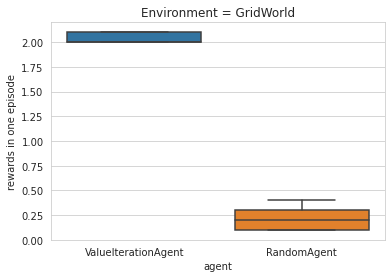

In [11]:
# The value of gamma above makes our VI agent quite bad! Let's optimize it.
vi_stats.optimize_hyperparams(n_trials=15, timeout=30, n_sim=5, n_fit=1, n_jobs=1, sampler_method='random', pruner_method='none')

# fit with optimized params
vi_stats.fit()

# ... and see the results
output = evaluate_policies([vi_stats, baseline_stats], n_sim=10)
